## Accessing PST Statistical Summaries via the Data Product Dashboard

This notebook demonstrates how to 
* access the Data Product Dashboard
* download a Statistical Summary File output by the PST Voltage Recorder
* display the attributes of the file
* plot the statistical summaries contained in the file

#### Setup imports for notebook

In [1]:
import tarfile
from typing import Tuple

import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt

from ska_pst.stat import Statistics

#### Set the URL of the Data Product Dashboard API

Use the following default value when running this notebook using the PST JupyterLab instance that is deployed with the `test-parent` chart.

In [2]:
BASE_URL = "http://ska-dataproduct-api:8000"

Uncomment the following if you're running this notebook on a machine with port 8000 forwarded to the Data Product Dashboard API

In [3]:
# BASE_URL = "http://localhost:8000"

### Update the list of available data products

Re-index the data products endpoint if metadata have been added or changed since the previous indexing.

In [4]:
response = requests.get(f"{BASE_URL}/reindexdataproducts")

### Get the latest PST Voltage Recorder Statistical Summary File from the data products endpoint

In [5]:
response = requests.get(f"{BASE_URL}/dataproductlist")
products = response.json()

last_dataproduct_file = ""
pst_path = "pst-low"
for product in products:
    dataproduct_file = product["dataproduct_file"]
    if pst_path in dataproduct_file:
        last_dataproduct_file = dataproduct_file

if last_dataproduct_file == "":
    raise FileNotFoundError(f"No dataproduct file includes {pst_path} in its path")

print(f"Loading statistical summary data from from {last_dataproduct_file}")

stat_folder = last_dataproduct_file + "/stat"
data = {"fileName": stat_folder, "relativePathName": stat_folder}
response = requests.post(f"{BASE_URL}/download", json=data)

tar_filename = "/tmp/stat.tar"
with open(tar_filename, "wb") as fd:
    for chunk in response.iter_content(chunk_size=4096):
        fd.write(chunk)

with tarfile.open(tar_filename, "r") as tar:
    file_list = tar.getnames()
    h5_files = [file for file in file_list if file.endswith(".h5")]
    statfile = h5_files[-1]
    tar.extract(statfile, path="/tmp")

statfile = "/tmp/" + statfile

Loading statistical summary data from from eb-n269-20231121-17899/pst-low/866


## Plot Statistics Using the STAT Data Access Library


In [6]:
stats = Statistics.load_from_file(statfile)

Display the current header data and assert the values in the header/metadata are the what are expected based on the scan configuration

In [7]:
stats.header

Key                   Value
0              File Format Version                   1.0.0
1               Execution Block ID  eb-n269-20231121-17899
2                        Telescope                  SKALow
3                          Scan ID                     866
4                          Beam ID                       4
5                   UTC Start Time     2023-11-21-21:50:53
6                Start Scan Offset               20.171981
7                  End Scan Offset               29.999186
8                  Frequency (MHz)                  1000.0
9                  Bandwidth (MHz)                  1.5625
10            Start Channel Number                       0
11              End Channel Number                     431
12              Num. Polarisations                       2
13                 Num. Dimensions                       2
14                   Num. Channels                     432
15             Num. Frequency Bins                     432
16              Num. Temporal Bins                    1481
17             Num. Histogram Bins                   65536
18  Num. Histogram Bins (Rebinned)                     256
19                    Num. Samples                20473344
20      Num. Samples (RFI Excised)                20473344
21            Num. Invalid Packets                       0

Display the frequency averaged stats for all channels

In [8]:
stats.frequency_averaged_stats

Mean        Var.  Clipped
Polarisation Dimension                               
A            Real      -0.215687  103.109695        0
             Imag      -0.215244  103.159134        0
B            Real      -0.216988  103.252815        0
             Imag      -0.215776  103.208824        0

Display the frequency averaged stats for the RFI excised data

In [9]:
stats.frequency_averaged_stats_rfi_excised

Mean        Var.  Clipped
Polarisation Dimension                               
A            Real      -0.215687  103.109695        0
             Imag      -0.215244  103.159134        0
B            Real      -0.216988  103.252815        0
             Imag      -0.215776  103.208824        0

Display sample counts per channel

A future improvement of the DAL would provide this something like and return a Pandas data frame directly:

```python
stats.num_samples_spectrum
```

In [10]:
samples = stats.metadata.num_samples_spectrum
channel_nums = stats.channel_numbers
df = pd.DataFrame(data={"channel_num": channel_nums, "num_samples": samples})
df

channel_num  num_samples
0              0        47392
1              1        47392
2              2        47392
3              3        47392
4              4        47392
..           ...          ...
427          427        47392
428          428        47392
429          429        47392
430          430        47392
431          431        47392

[432 rows x 2 columns]

### Display Plots using STAT Data Access Library

The following shows how to do plot data based on the STAT DAL rather than using the HD5F file directly.

The utility methods provided here will be moved to the DAL in the future.

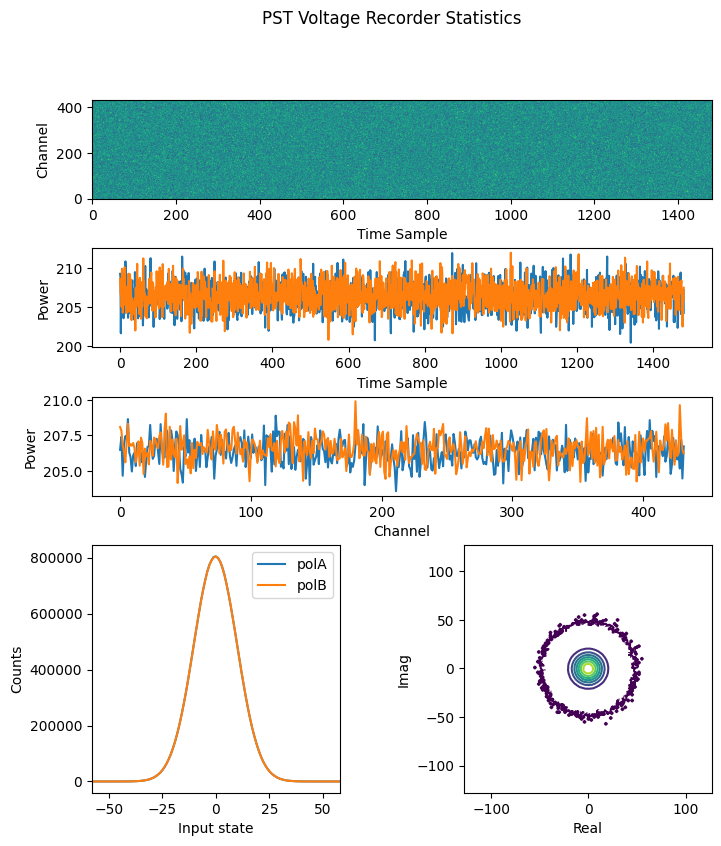

In [11]:
fig = plt.figure(figsize=(8, 9))
fig.suptitle("PST Voltage Recorder Statistics")

gs = plt.GridSpec(5, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, :])
ax4 = plt.subplot(gs[3:, 0])
ax5 = plt.subplot(gs[3:, 1])

# Spectrogram Plot
spectrogram_pol_a = stats.pol_a_spectrogram
mean = np.mean(spectrogram_pol_a)
stddev = np.std(spectrogram_pol_a)
minval = float(mean - 2.0 * stddev)
maxval = float(mean + 2.0 * stddev)
ax1.imshow(spectrogram_pol_a, origin="lower", vmin=minval, vmax=maxval, aspect="auto")
ax1.set_xlabel("Time Sample")
ax1.set_ylabel("Channel")

# Timeseries Plot
pol_a_timeseries = stats.pol_a_timeseries
pol_b_timeseries = stats.pol_b_timeseries

ax2.plot(pol_a_timeseries["Mean"], label="polA")
ax2.plot(pol_b_timeseries["Mean"], label="polB")
ax2.set_ylabel("Power")
ax2.set_xlabel("Time Sample")

# Spectral Power Plot
pol_a_spectral_power = stats.pol_a_spectral_power
pol_b_spectral_power = stats.pol_b_spectral_power

ax3.plot(pol_a_spectral_power["Mean"], label="polA")
ax3.plot(pol_b_spectral_power["Mean"], label="polB")
ax3.set_xlabel("Channel")
ax3.set_ylabel("Power")

# Histogram
pol_a_real_histogram = stats.pol_a_real_histogram
pol_a_imag_histogram = stats.pol_a_imag_histogram

# find last zero count before any counts


def find_count_bounds(df: pd.DataFrame, column: str = "Count") -> Tuple[int, int]:
    nonzeros = df[df[column] != 0].index
    return (nonzeros[0], nonzeros[-1])  # type: ignore


nbin = stats.metadata.histogram_nbin
pol_a_real_histogram = stats.pol_a_real_histogram
pol_b_real_histogram = stats.pol_b_real_histogram

(pol_a_low_idx, pol_a_high_idx) = find_count_bounds(stats.pol_a_real_histogram)
(pol_b_low_idx, pol_b_high_idx) = find_count_bounds(stats.pol_b_real_histogram)

low_idx = max(0, min(pol_a_low_idx, pol_b_low_idx) - 1)
high_idx = min(nbin - 1, max(pol_a_high_idx, pol_b_high_idx) + 1)
centre_idx = nbin // 2
diff = max(np.abs(centre_idx - low_idx), np.abs(high_idx - centre_idx))
low_idx = max(0, centre_idx - diff)
high_idx = min(nbin - 1, centre_idx + diff)

xbins = np.arange(low_idx, high_idx + 1)
pol_a_real_histogram = pol_a_real_histogram.iloc[xbins]["Count"]  # type: ignore
pol_b_real_histogram = pol_b_real_histogram.iloc[xbins]["Count"]  # type: ignore

xbins = xbins - centre_idx

ax4.set_xlim((xbins[0], xbins[-1]))
ax4.plot(xbins, pol_a_real_histogram, label="polA")
ax4.plot(xbins, pol_b_real_histogram, label="polB")
ax4.set_xlabel("Input state")
ax4.set_ylabel("Counts")
ax4.legend()

# 2D Histogram
pol_a_2d_data = stats.pol_a_rebinned_histogram2d
nrebin = stats.metadata.nrebin
n = nrebin // 2
histogram_bounds = np.arange(-n, n)
ax5.contour(histogram_bounds, histogram_bounds, pol_a_2d_data)
ax5.set_xlabel("Real")
ax5.set_ylabel("Imag")

plt.show()